# Importation des librairies necessaires

In [104]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.utils import resample
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.feature_selection import RFE

# Importation des données

In [105]:
df = pd.read_csv('data/data.csv')

df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [106]:
# Information sur les donées
print('data shape:', df.shape)
df.info()

data shape: (7043, 21)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   gender            7043 non-null   object 
 2   SeniorCitizen     7043 non-null   int64  
 3   Partner           7043 non-null   object 
 4   Dependents        7043 non-null   object 
 5   tenure            7043 non-null   int64  
 6   PhoneService      7043 non-null   object 
 7   MultipleLines     7043 non-null   object 
 8   InternetService   7043 non-null   object 
 9   OnlineSecurity    7043 non-null   object 
 10  OnlineBackup      7043 non-null   object 
 11  DeviceProtection  7043 non-null   object 
 12  TechSupport       7043 non-null   object 
 13  StreamingTV       7043 non-null   object 
 14  StreamingMovies   7043 non-null   object 
 15  Contract          7043 non-null   object 
 16  PaperlessBilling  7

On a dans  `18` variables catecorielle `1` variable entière et `2` variable flotantes

In [107]:
# Nombre de valures unique par colonne
df.nunique()

customerID          7043
gender                 2
SeniorCitizen          2
Partner                2
Dependents             2
tenure                73
PhoneService           2
MultipleLines          3
InternetService        3
OnlineSecurity         3
OnlineBackup           3
DeviceProtection       3
TechSupport            3
StreamingTV            3
StreamingMovies        3
Contract               3
PaperlessBilling       2
PaymentMethod          4
MonthlyCharges      1585
TotalCharges        6531
Churn                  2
dtype: int64

Effectivemet chaque ligne represente un unique client, identifié par son identifiant unique `customer ID`

# Analyse Exploratoire

In [108]:
# Variables catégorielles

categorical_columns = df.nunique()[df.nunique() < 5].keys().to_list()

categorical_columns

['gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'MultipleLines',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'Contract',
 'PaperlessBilling',
 'PaymentMethod',
 'Churn']

In [109]:
type(df["Churn"])

pandas.core.series.Series

In [110]:
# Création d'une fonction de construction de graphiques à barres et de manière interactive

def bar_plot(column):
  """
    params: 
        column: string
    Une fonction qui prend en entrée une variable et affiche la distribution de celle-ci

    
  """
  df[column].value_counts(normalize = True).plot(kind = 'bar')
  plt.ylabel('proportion')
  plt.title('Distribution of ' + str(column))
  return plt.show()



In [111]:
#Interact

interact(bar_plot, column= categorical_columns)

interactive(children=(Dropdown(description='column', options=('gender', 'SeniorCitizen', 'Partner', 'Dependent…

<function __main__.bar_plot(column)>

Il y a plus de clients qui ne se sont pas désabonnés (plus de 70%) que de clients qui se sont désabonné (moins de 30%). Donc nous avons un problème de déséquilibre qu'il faudra absolument résoudre car cela peut impacter négativement la performance des modèles de classification que nous allons construire.

la distribution des données entre les différents sexes est à peu près également répartie.

Le nombre de clients qui sont des personnes âgées (moins de 20%) est bien inférieur à celui des clients jeunes (plus de 80%).

La variable Partner indique si le client a un partenaire (Yes) ou pas (No). Les deux catégories ont pratiquement la même proportion.

Répétons le même processus cette fois-ci pour les variables numériques.

In [112]:
# Echantillonnement aléatoire de la variable 'TotalCharges'

df['TotalCharges'].sample(10)

6755     3313.4
293       567.8
2522    3942.45
2739     6383.9
6006     678.75
2667       8405
2542    2495.15
6113     1570.7
2891       79.7
5004     6953.4
Name: TotalCharges, dtype: object

In [113]:
# Variables quantitatives

numerical_columns = ['tenure', 'MonthlyCharges', 'TotalCharges']

# Création d'une fonction de construction d'histogrammes et de manière interactive

def hist_plot(b):
  sns.displot(df[b], kde=False)
  plt.title('Histogram of '+str(b))
  return plt.show()

# Conversion du type des valeurs de la variable 'TotalCharges' en float (décimal)

df['TotalCharges'] = df['TotalCharges'].replace(' ', np.nan).astype(float)

In [114]:
#Interact

interact(hist_plot, b = numerical_columns)



interactive(children=(Dropdown(description='b', options=('tenure', 'MonthlyCharges', 'TotalCharges'), value='t…

<function __main__.hist_plot(b)>

L avariable `TotalCharge` presente une asymetrie qui sera traité par la suite

In [115]:
# Coefficient d'asymétrie de la variable 'TotalCharges'

df['TotalCharges'].skew()

0.961642499724251

In [116]:
# Création d'une fonction de construction de boîtes à moustaches et de manière interactive

def box_plot(b):
  sns.boxplot(y = df[b])
  plt.title('Boxplot of ' + str(b))
  return plt.show()

#Interact

interact(box_plot, b = numerical_columns)

interactive(children=(Dropdown(description='b', options=('tenure', 'MonthlyCharges', 'TotalCharges'), value='t…

<function __main__.box_plot(b)>

Bien que ces variables numerique n'aient pas de valeures aberantes, elle presente quand bien meme des asymetries qui doivent etre traité pour ne pas creer des soucis de prediction à notre futur model

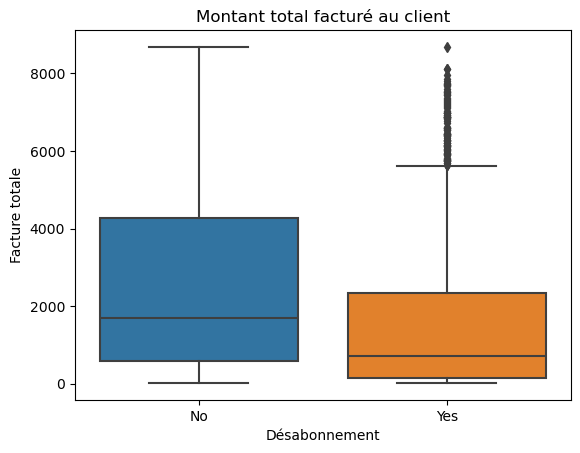

In [117]:
# TotalCharges VS Churn 

sns.boxplot(x='Churn', y='TotalCharges', data=df)
plt.xlabel('Désabonnement')
plt.ylabel('Facture totale')
plt.title('Montant total facturé au client')
plt.show()

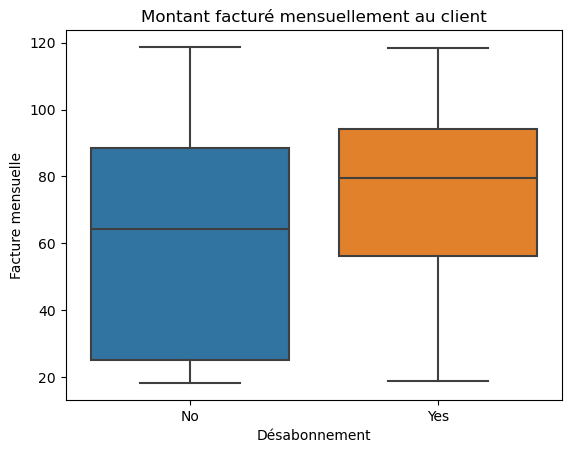

In [118]:
# MonthlyCharges VS Churn

sns.boxplot(x='Churn', y='MonthlyCharges', data=df)
plt.xlabel('Désabonnement')
plt.ylabel('Facture mensuelle')
plt.title('Montant facturé mensuellement au client')
plt.show()

On remarque  que le motant de  facturation mensuelle est plus elevé chez les les clients qui se desabonnen cela pourrait signifier que la facturation mensuelle peut etre une raison de desabonement

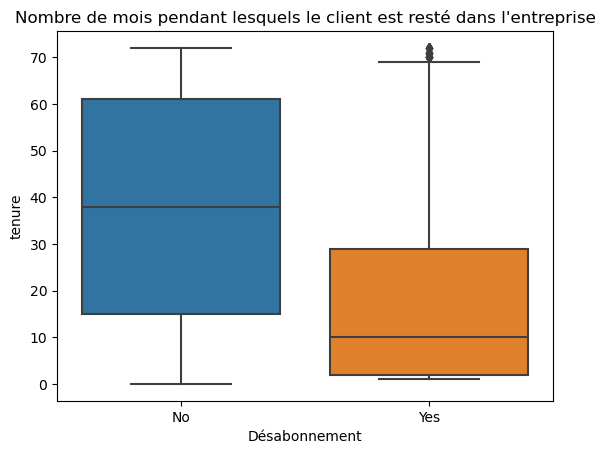

In [119]:
# tenure VS Churn

sns.boxplot(x='Churn', y='tenure', data=df)
plt.xlabel('Désabonnement')
plt.title("Nombre de mois pendant lesquels le client est resté dans l'entreprise")
plt.show()

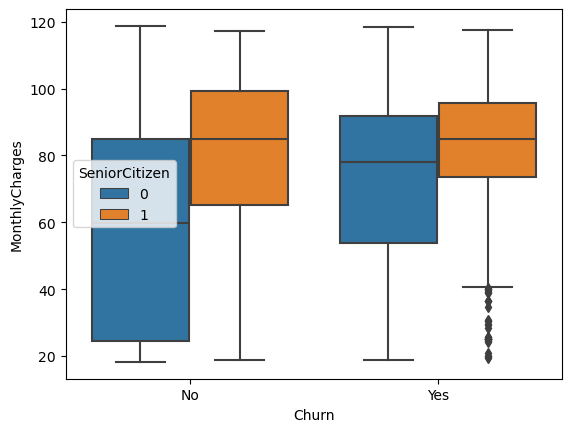

In [120]:
# MonthlyCharges VS Churn by SeniorCitizen

sns.boxplot(x = 'Churn', y = 'MonthlyCharges', data=df, hue = 'SeniorCitizen');

il semble que les personnes agés soient plus facturés que les jeunes

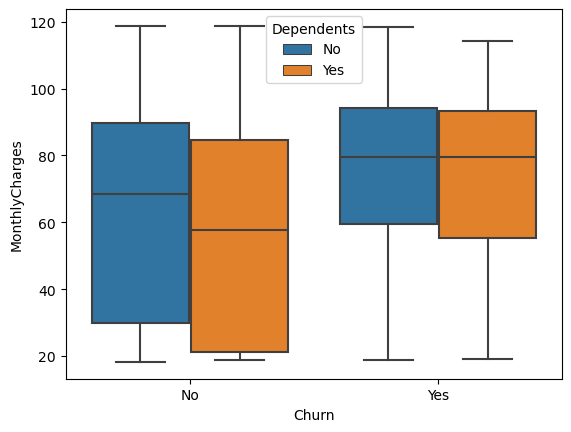

In [121]:
# MonthlyCharges VS Churn by Dependents

sns.boxplot(x = 'Churn', y = 'MonthlyCharges', data=df, hue = 'Dependents');

In [122]:
# Describtion
df.describe()

,SeniorCitizen,tenure,MonthlyCharges,TotalCharges
count,7043.000000,7043.000000,7043.000000,7032.000000
mean,0.162147,32.371149,64.761692,2283.300441
std,0.368612,24.559481,30.090047,2266.771362
min,0.000000,0.000000,18.250000,18.800000
25%,0.000000,9.000000,35.500000,401.450000
50%,0.000000,29.000000,70.350000,1397.475000
75%,0.000000,55.000000,89.850000,3794.737500
max,1.000000,72.000000,118.750000,8684.800000


on peut le remarquer que ces variables n'ont pas la meme echelle , et cela pourrait causer un biais pour notre model, i aurra des dificulté  à bien fonctionner

# Pré-traitement des données

In [140]:
# copy des données, pour avoir la version orginal et revenir à ça à tout moment
data = df.copy()

(data.isna().sum().sort_values(ascending=False))/data.shape[0]

TotalCharges        0.001562
customerID          0.000000
DeviceProtection    0.000000
MonthlyCharges      0.000000
PaymentMethod       0.000000
PaperlessBilling    0.000000
Contract            0.000000
StreamingMovies     0.000000
StreamingTV         0.000000
TechSupport         0.000000
OnlineBackup        0.000000
gender              0.000000
OnlineSecurity      0.000000
InternetService     0.000000
MultipleLines       0.000000
PhoneService        0.000000
tenure              0.000000
Dependents          0.000000
Partner             0.000000
SeniorCitizen       0.000000
Churn               0.000000
dtype: float64

les valeures manquantes dans la colonne `TotalCharges` est de `0.001562%` donc on pourra les suprimer

In [141]:
# Suppression des valeurs manquantes

data.dropna(inplace=True)

(data.isna().sum().sort_values(ascending=False))/data.shape[0]

customerID          0.0
DeviceProtection    0.0
TotalCharges        0.0
MonthlyCharges      0.0
PaymentMethod       0.0
PaperlessBilling    0.0
Contract            0.0
StreamingMovies     0.0
StreamingTV         0.0
TechSupport         0.0
OnlineBackup        0.0
gender              0.0
OnlineSecurity      0.0
InternetService     0.0
MultipleLines       0.0
PhoneService        0.0
tenure              0.0
Dependents          0.0
Partner             0.0
SeniorCitizen       0.0
Churn               0.0
dtype: float64

une autre chose dans le pre-traitement des données est l'encodage

In [142]:
# Encodage des variables binaires

data['gender'] = data['gender'].apply(lambda row: 1 if row == 'female' else 0)

binary_columns = data.drop('gender', axis=1).nunique()[data.drop('gender', axis=1).nunique() < 3].keys().to_list()

binary_columns

['SeniorCitizen',
 'Partner',
 'Dependents',
 'PhoneService',
 'PaperlessBilling',
 'Churn']

In [143]:
for column in binary_columns:
  data[column] = data[column].apply(lambda row: 1 if row == 'Yes' else 0)

In [145]:
# Encodage des variables catégorielles restantes 

remaining_cat_vars = data[categorical_columns].nunique()[data[categorical_columns].nunique() > 2].keys().to_list()

remaining_cat_vars_dummies = pd.get_dummies(data=data[remaining_cat_vars], columns=remaining_cat_vars, drop_first=True).astype("int")

In [146]:
# Nouvelle dataframe

data = pd.concat([data['gender'], data[binary_columns], remaining_cat_vars_dummies, data[numerical_columns]], axis=1)

In [147]:
data.head()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,Churn,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,...,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
0,0,0,1,0,0,1,0,1,0,0,...,0,0,0,0,0,1,0,1,29.85,29.85
1,0,0,0,0,1,0,0,0,0,0,...,0,0,1,0,0,0,1,34,56.95,1889.50
2,0,0,0,0,1,1,1,0,0,0,...,0,0,0,0,0,0,1,2,53.85,108.15
3,0,0,0,0,0,0,0,1,0,0,...,0,0,1,0,0,0,0,45,42.30,1840.75
4,0,0,0,0,1,1,1,0,0,1,...,0,0,0,0,0,1,0,2,70.70,151.65


On va transformer la  variable tres asymetrique `TotalCharge` par la fonction racince carée

c:\Users\SAMUEL\anaconda3\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


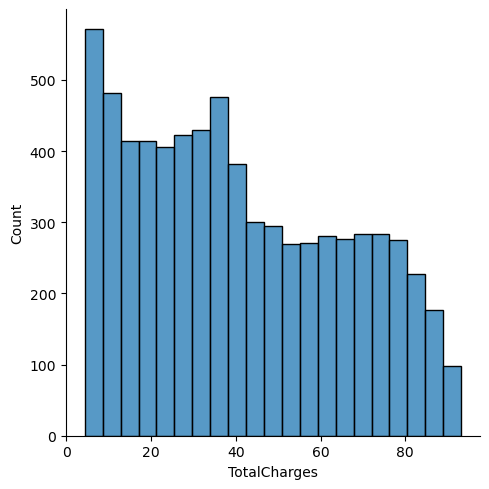

In [148]:
# Transformation de la variable 'TotalCharges' 

data['TotalCharges'] = np.sqrt(data['TotalCharges'])

# Histogramme de la variable transformée

sns.displot(data['TotalCharges'], kde=False);

In [149]:
# Coefficient d'asymétrie de la variable 'TotalCharges' après transformation

data['TotalCharges'].skew()

0.3089261418986736

### Split Data

In [150]:
# Données d'entraînement (60%), de validation (20%) et de test (20%)

X = data.drop('Churn', axis = 1)

y = data['Churn']

seed = 1111

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.4, random_state = seed, stratify = y)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = 0.5, random_state = seed, stratify = y_test)

In [151]:
# Fréquence des classes dans y

pd.DataFrame(y).value_counts(normalize = True)

Churn
0        0.734215
1        0.265785
Name: proportion, dtype: float64

In [152]:
# Fréquence des classes dans y_train

pd.DataFrame(y_train).value_counts(normalize = True)

Churn
0        0.734297
1        0.265703
Name: proportion, dtype: float64

In [153]:
# Fréquence des classes dans y_val

pd.DataFrame(y_val).value_counts(normalize = True)

Churn
0        0.733997
1        0.266003
Name: proportion, dtype: float64

In [155]:
# Résolution du problème de déséquilibre de classe : Méthode de sur-échantillonnage de la classe minoritaire

X2 = X_train

X2['Churn'] = y_train.values

minority = X2[X2.Churn == 1]

majority = X2[X2.Churn == 0]

minority_upsampled = resample(minority, replace = True, n_samples = len(majority), random_state=seed)

upsampled = pd.concat([majority, minority_upsampled])

upsampled.shape

(6196, 31)

In [156]:
# Vérification

upsampled['Churn'].value_counts(normalize = True)

Churn
0    0.5
1    0.5
Name: proportion, dtype: float64

In [157]:
# Données d'entraînement sur la base la méthode de sur-échantillonnage de la classe minoritaire

X_train_up = upsampled.drop('Churn', axis = 1)

y_train_up = upsampled['Churn']

In [159]:
# Résolution du problème de déséquilibre de classe : Méthode de sous-échantillonnage de la classe majoritaire

majority_downsampled = resample(majority, replace=False, n_samples = len(minority), random_state = seed)

downsampled = pd.concat([minority, majority_downsampled])

downsampled.shape

(2242, 31)

In [160]:
downsampled["Churn"].value_counts(normalize= True)

Churn
1    0.5
0    0.5
Name: proportion, dtype: float64

In [161]:
# y_train et X_train

y_train = X_train['Churn']

X_train = X_train.drop('Churn', axis=1)

In [162]:
# Définition des données d'entraînement 
# Choix possibles : (X_train, y_train), (X_train_up, y_train_up) et (X_train_down, y_train_down)

train_features = X_train_up

train_labels = y_train_up

### Normalisation

In [163]:
# Normalisation des variables indépendantes des différents ensembles de données
    # Vous pouvez choisir de standardiser au lieu de normaliser #StandardScaler()

scaler = MinMaxScaler()

mod_scaler = scaler.fit(train_features)
train_features = mod_scaler.transform(train_features)
X_val = mod_scaler.transform(X_val)
X_test = mod_scaler.transform(X_test)

# Retranformation en Dataframe

train_features = pd.DataFrame(train_features, columns = X.columns)
X_val = pd.DataFrame(X_val, columns = X.columns)
X_test = pd.DataFrame(X_test, columns = X.columns)

In [165]:
train_features.describe()

,gender,SeniorCitizen,Partner,Dependents,PhoneService,PaperlessBilling,MultipleLines_No phone service,MultipleLines_Yes,InternetService_Fiber optic,InternetService_No,...,StreamingMovies_No internet service,StreamingMovies_Yes,Contract_One year,Contract_Two year,PaymentMethod_Credit card (automatic),PaymentMethod_Electronic check,PaymentMethod_Mailed check,tenure,MonthlyCharges,TotalCharges
count,6196.0,6196.0,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,...,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000,6196.000000
mean,0.0,0.0,0.438509,0.248870,0.904939,0.650904,0.095061,0.439638,0.530826,0.166720,...,0.166720,0.413331,0.165752,0.168496,0.186572,0.419787,0.205939,0.377363,0.496667,0.379936
std,0.0,0.0,0.496244,0.432393,0.293323,0.476723,0.293323,0.496383,0.499089,0.372756,...,0.372756,0.492471,0.371888,0.374336,0.389599,0.493564,0.404419,0.337783,0.287344,0.273721
min,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.056338,0.269652,0.142192
50%,0.0,0.0,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,1.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.281690,0.563682,0.332135
75%,0.0,0.0,1.000000,0.000000,1.000000,1.000000,0.000000,1.000000,1.000000,0.000000,...,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.676056,0.724876,0.591234
max,0.0,0.0,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# Modelisation

### Metrics

Ici nous prenons le F1-score

In [166]:
# Sélection des meilleures variables prédictrices

rf = RandomForestClassifier()

rf.fit(train_features, train_labels)

print(classification_report(y_val, rf.predict(X_val)))

              precision    recall  f1-score   support

           0       0.83      0.86      0.84      1032
           1       0.56      0.51      0.53       374

    accuracy                           0.76      1406
   macro avg       0.70      0.68      0.69      1406
weighted avg       0.76      0.76      0.76      1406



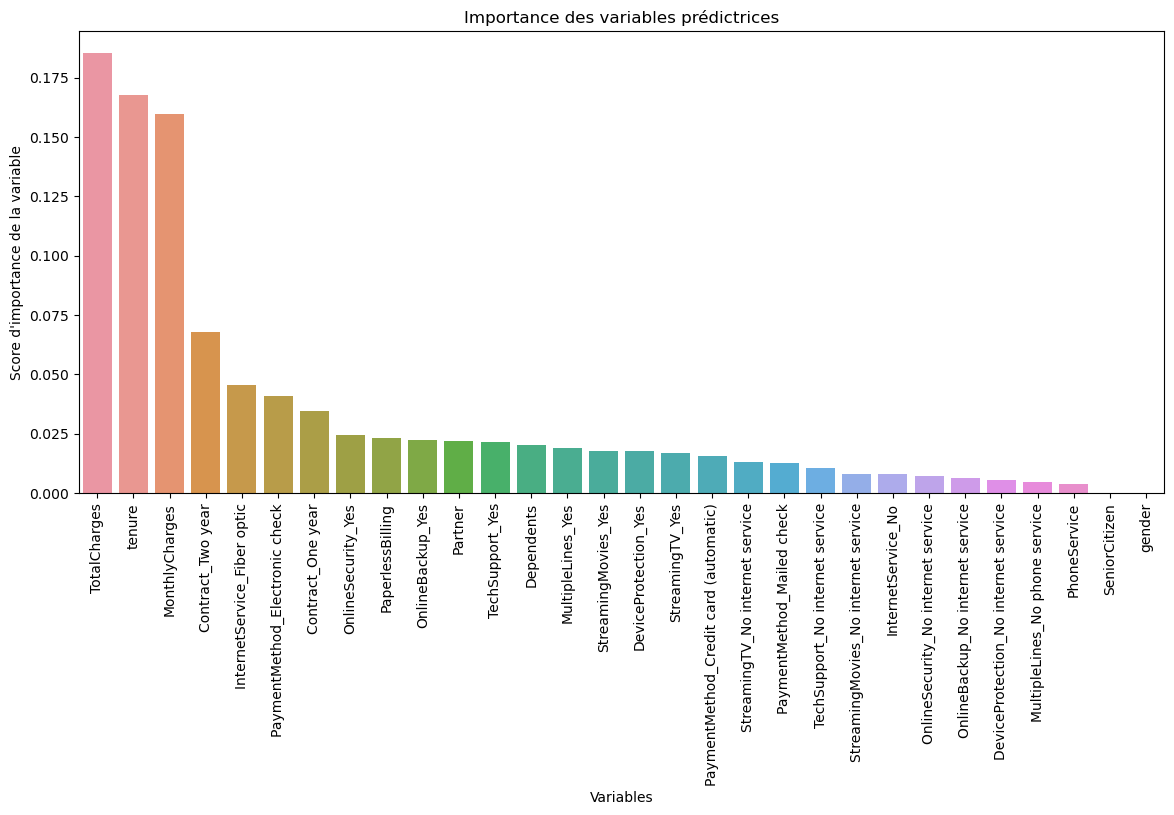

In [167]:
plt.figure(figsize=(14, 6))

vars_imp = pd.Series(rf.feature_importances_, index = train_features.columns).sort_values(ascending=False)

sns.barplot(x = vars_imp.index, y=vars_imp)
plt.xticks(rotation=90)
plt.xlabel("Variables")
plt.ylabel("Score d'importance de la variable")
plt.title("Importance des variables prédictrices")
plt.show()

In [168]:
# Affichage de vars_imp

vars_imp

TotalCharges                             0.185388
tenure                                   0.167606
MonthlyCharges                           0.159585
Contract_Two year                        0.067650
InternetService_Fiber optic              0.045508
PaymentMethod_Electronic check           0.040933
Contract_One year                        0.034659
OnlineSecurity_Yes                       0.024245
PaperlessBilling                         0.023111
OnlineBackup_Yes                         0.022118
Partner                                  0.021965
TechSupport_Yes                          0.021299
Dependents                               0.019969
MultipleLines_Yes                        0.019070
StreamingMovies_Yes                      0.017512
DeviceProtection_Yes                     0.017492
StreamingTV_Yes                          0.016732
PaymentMethod_Credit card (automatic)    0.015630
StreamingTV_No internet service          0.012977
PaymentMethod_Mailed check               0.012642


In [169]:
# Variables sélectionnées pour les algorithmes

seuil = 0.004

vars_selected = vars_imp[vars_imp > seuil].index.to_list()

train_features = train_features[vars_selected]

X_val = X_val[vars_selected]

X_test = X_test[vars_selected]

In [171]:
train_features.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6196 entries, 0 to 6195
Data columns (total 27 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   TotalCharges                           6196 non-null   float64
 1   tenure                                 6196 non-null   float64
 2   MonthlyCharges                         6196 non-null   float64
 3   Contract_Two year                      6196 non-null   float64
 4   InternetService_Fiber optic            6196 non-null   float64
 5   PaymentMethod_Electronic check         6196 non-null   float64
 6   Contract_One year                      6196 non-null   float64
 7   OnlineSecurity_Yes                     6196 non-null   float64
 8   PaperlessBilling                       6196 non-null   float64
 9   OnlineBackup_Yes                       6196 non-null   float64
 10  Partner                                6196 non-null   float64
 11  Tech

#### Logistic Regression

In [172]:
# Dictionnaire des hyperparamètres

param_grid = {'C':[0.001, 0.01, 1, 10, 50, 100, 500]}

# Objet GridSearchCV

grid_logreg_class = GridSearchCV(estimator=LogisticRegression(random_state=seed, max_iter=500), 
                                 param_grid=param_grid, 
                                 scoring='f1', 
                                 cv=5)

# Entraînement de l'algorithme

logreg_model = grid_logreg_class.fit(train_features, train_labels)

# Meilleur score et meilleur hyperparamètre

print(round(logreg_model.best_score_, 3))

print(logreg_model.best_estimator_)

0.79
LogisticRegression(C=10, max_iter=500, random_state=1111)


In [173]:
# Fonction d'évaluation de la performance d'un modèle

def model_evaluation(model, features, labels):
  pred = model.predict(features)
  print(classification_report(labels, pred))

In [174]:
# Evaluation du modèle de régression logistique

model_evaluation(logreg_model.best_estimator_, X_val, y_val)

              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1032
           1       0.51      0.74      0.61       374

    accuracy                           0.74      1406
   macro avg       0.70      0.74      0.71      1406
weighted avg       0.79      0.74      0.76      1406



In [175]:
# Création d'une fonction de construction d'un modèle avec utilisation de l'algorithme RFE

def model_with_rfe(model):
  rfe_model = RFE(estimator=model, verbose=0)
  rfe_model.fit(train_features, train_labels)
  mask = rfe_model.support_
  reduced_X = train_features.loc[:, mask]
  print(reduced_X.columns)
  return rfe_model

In [176]:
# Logistic Regression RFE

rfe_logreg_model = model_with_rfe(logreg_model.best_estimator_)

rfe_logreg_model

Index(['TotalCharges', 'MonthlyCharges', 'Contract_Two year',
       'InternetService_Fiber optic', 'PaymentMethod_Electronic check',
       'Contract_One year', 'PaperlessBilling', 'MultipleLines_Yes',
       'StreamingMovies_Yes', 'StreamingTV_Yes',
       'StreamingMovies_No internet service', 'InternetService_No',
       'OnlineSecurity_No internet service'],
      dtype='object')


RFE(estimator=LogisticRegression(C=10, max_iter=500, random_state=1111))

In [177]:
# Evaluation du modèle de régression logistique avec RFE

model_evaluation(rfe_logreg_model, X_val, y_val)

              precision    recall  f1-score   support

           0       0.89      0.74      0.81      1032
           1       0.51      0.74      0.60       374

    accuracy                           0.74      1406
   macro avg       0.70      0.74      0.70      1406
weighted avg       0.79      0.74      0.75      1406



#### Model de Foret aleatoire

In [178]:
# Dictionnaire des hyperparamètres

param_grid_rf = {'n_estimators':[10, 50, 100, 500, 1000], 
                 'max_depth':[3, 5, 10, 20, None]}

# Objet GridSearchCV

grid_rf_class = GridSearchCV(estimator=RandomForestClassifier(random_state=seed), 
                             param_grid = param_grid_rf, 
                             scoring='f1', 
                             cv=5)

# Entraînement de l'algorithme

rf_model = grid_rf_class.fit(train_features, train_labels)

# Meilleur score et meilleur hyperparamètre

print(round(rf_model.best_score_, 3))

print(rf_model.best_estimator_)

0.91
RandomForestClassifier(max_depth=20, n_estimators=50, random_state=1111)
